In [8]:
import tensorflow as tf
print("GPUs detectadas:", tf.config.list_physical_devices('GPU1'))

GPUs detectadas: []


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("agrigorev/clothing-dataset-full")

print("Path to dataset files:", path)

In [5]:
path = "imgs/"

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

print(os.listdir(path))


['images.csv', 'images_original', 'images_compressed']


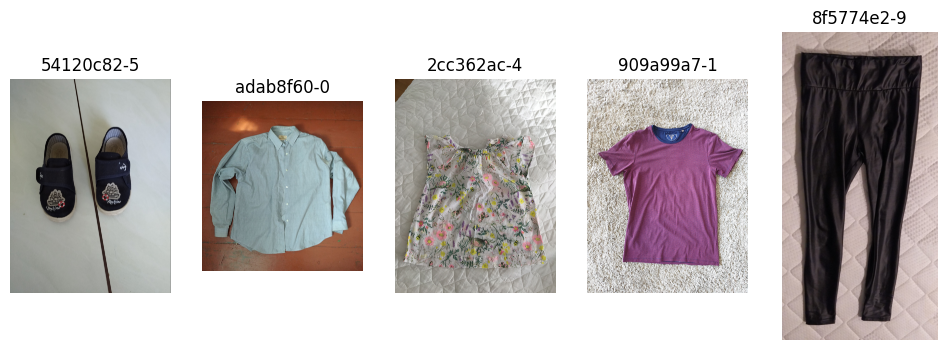

In [ ]:
if path is None:
    candidates_to_check = []
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)):
        candidates_to_check.extend(candidates)
    candidates_to_check.append('.')

    images_path = None
    for root in candidates_to_check:
        possible = [
            os.path.join(root, "images_original", "train"),
            os.path.join(root, "images_original"),
            os.path.join(root, "train"),
            root
        ]
        for p in possible:
            if p and os.path.exists(p) and os.path.isdir(p):
                if os.path.basename(p) == "images_original":
                    train_p = os.path.join(p, "train")
                    if os.path.exists(train_p) and os.path.isdir(train_p):
                        images_path = train_p
                        break
                images_path = p
                break
        if images_path:
            break

    if images_path is None:
        raise FileNotFoundError(
            "No se encontró la ruta del dataset. Establece la variable 'path' o descarga el dataset "
            "(por ejemplo: path = kagglehub.dataset_download(...))."
        )
else:
    images_path = os.path.join(path, "images_original", "train")
    if not os.path.exists(images_path):7
        if os.path.exists(os.path.join(path, "images_original", "train")):
            images_path = os.path.join(path, "images_original", "train")
        elif os.path.exists(os.path.join(path, "images_original")):
            images_path = os.path.join(path, "images_original")
        elif os.path.exists(os.path.join(path, "train")):
            images_path = os.path.join(path, "train")
        elif os.path.isdir(path):
            images_path = path
        else:
            raise FileNotFoundError(f"No se encontró la carpeta de imágenes bajo path={path}")

image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:5]
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_path}")

n = len(image_files)
plt.figure(figsize=(12, 4))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(images_path, img_name)
    img = Image.open(img_path)

    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name[:10])

plt.show()


In [23]:
import pandas as pd 
import cv2
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC


df = pd.read_csv(os.path.join(path, "images.csv"))
print(df.head())

                                  image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False


In [24]:
IMAGE_PATH = "imgs/images_original/"
IMG_SIZE = 64  

X = []
y = []

for _, row in df.iterrows():
    img_file = os.path.join(IMAGE_PATH, row['image'] + ".jpg")
    
    img = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.flatten()        # 64x64 → 4096
    X.append(img)
    y.append(row['label'])
    


In [25]:
X = np.array(X) / 255.0
le = LabelEncoder()
y = le.fit_transform(y)

print(le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

['Blazer' 'Blouse' 'Body' 'Dress' 'Hat' 'Hoodie' 'Longsleeve' 'Not sure'
 'Other' 'Outwear' 'Pants' 'Polo' 'Shirt' 'Shoes' 'Shorts' 'Skip' 'Skirt'
 'T-Shirt' 'Top' 'Undershirt']


In [26]:
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [27]:
svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale'
)

svm.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [28]:
y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.5124884366327475
              precision    recall  f1-score   support

      Blazer       0.60      0.24      0.34        25
      Blouse       0.00      0.00      0.00         5
        Body       0.78      0.47      0.58        15
       Dress       0.33      0.48      0.39        60
         Hat       0.56      0.31      0.40        29
      Hoodie       0.33      0.15      0.21        26
  Longsleeve       0.42      0.45      0.43       146
    Not sure       0.19      0.15      0.16        41
       Other       0.00      0.00      0.00        14
     Outwear       0.44      0.50      0.47        64
       Pants       0.75      0.77      0.76       145
        Polo       0.38      0.19      0.25        27
       Shirt       0.48      0.48      0.48        71
       Shoes       0.65      0.57      0.61        81
      Shorts       0.44      0.46      0.45        65
        Skip       0.00      0.00      0.00         3
       Skirt       0.42      0.16      0.23        3

/home/jhonatan/VisualCodeStudio/AprendizajePractica3/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jhonatan/VisualCodeStudio/AprendizajePractica3/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/jhonatan/VisualCodeStudio/AprendizajePractica3/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame